In [1]:
import pandas as pd
import os
import json
import torch
import numpy as np
from steams.data import KVyQVx
from steams.models.attention import dpnn3
from steams.trainer import AttentionTrainer,train, evaluation, prediction_prime, ensemble_prime
from steams.criterion import R2,RMSE,variance
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import geopandas as gpd

In [2]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))

In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [4]:
if torch.cuda.is_available():
    cuda_name = "1"
    num_workers=0
    pin_memory = True
    device = torch.device('cuda'+":"+cuda_name)
    #device = torch.device('cuda')
else:
    num_workers = 4
    pin_memory = False
    device = torch.device('cpu')

In [5]:
device

device(type='cpu')

## train/valid dataset

In [6]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "history_length": 0,
          "nb_sampling": 100
        },
        "X":{
          "path": "",
          "QUERY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 100
        }
    }

In [7]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_train")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_train")

train_dataset = KVyQVx(params)

In [8]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_valid")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_valid")

valid_dataset = KVyQVx(params)

In [9]:
#train_dataset[0]

## model, optimizer, criterion, scheduler

In [10]:
#model
model = dpnn3(input_k=2,input_v=1, hidden_size=32)

In [13]:
# optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #8e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# criterion
criterion = torch.nn.MSELoss()

# AttentionTrainer object
obj = AttentionTrainer(model,device)
obj.init_optimizer(optimizer)
obj.init_criterion(criterion)

## Training

In [14]:
# training
train(obj,train_dataset,valid_dataset,niter=200,n_iter_stop=20,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

  epoch     train     valid
0     0  0.640975  0.555618
  epoch     train     valid
0     1  0.640887  0.555634
  epoch     train     valid
0     2  0.640926  0.560736
  epoch     train     valid
0     3  0.641205  0.554748
  epoch     train    valid
0     4  0.647717  0.56043
  epoch    train     valid
0     5  0.64228  0.561043
  epoch     train     valid
0     6  0.645473  0.551063
  epoch     train     valid
0     7  0.644365  0.563274
  epoch     train     valid
0     8  0.635806  0.558879
  epoch     train     valid
0     9  0.641468  0.557977
  epoch     train     valid
0    10  0.639988  0.554987
  epoch     train     valid
0    11  0.639279  0.551404
  epoch     train     valid
0    12  0.634967  0.557147
  epoch     train    valid
0    13  0.641396  0.55353
  epoch     train     valid
0    14  0.640306  0.552982
  epoch     train     valid
0    15  0.641513  0.557266
  epoch     train     valid
0    16  0.636038  0.556716
  epoch     train     valid
0    17  0.634272  0.56103

In [15]:
obj.save_model(resdir,"1d-dpnn3")

## Evaluation

In [16]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [23]:
criterion = R2()
#criterion = torch.nn.MSELoss()
obj.init_criterion(criterion)

In [24]:
evaluation(obj,eval_dataset,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

-1.6547279432415962


In [25]:
criterion = RMSE()
obj.init_criterion(criterion)

In [26]:
evaluation(obj,eval_dataset,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.37455862760543823


In [27]:
criterion = variance()
obj.init_criterion(criterion)

In [28]:
evaluation(obj,eval_dataset,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.07560518151149154


## QQplot

In [29]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [30]:
results = prediction_prime(obj,eval_dataset)

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,tmp_df],ignore_index=True,axis=0)


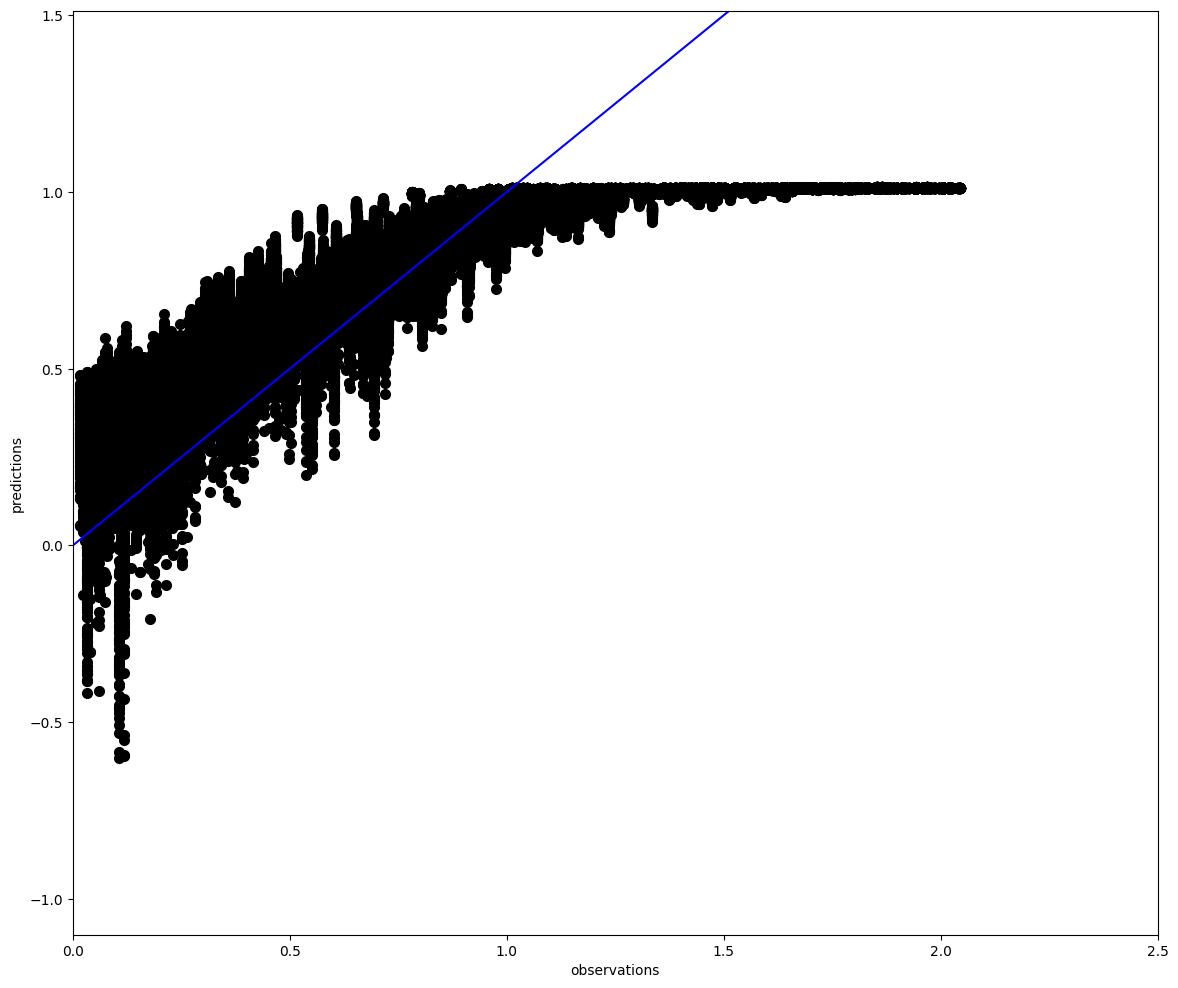

In [31]:
pred_name = ['pred_' + v for v in eval_dataset.VALUE_X]

fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(results.loc[:,eval_dataset.VALUE_X],results.loc[:,pred_name], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 2.5)
ax.set_ylim(results.loc[:,pred_name].min().item()-0.5, results.loc[:,pred_name].max().item()+0.5)
ax.set(xlabel='observations', ylabel='predictions')

fig_filename = os.path.join(parent_dir,'fig','1d-qqplot.png')
plt.savefig(fig_filename, dpi = 300)

## Illustration of Wq on a map

In [32]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_all_6400")
params['X']['nb_location'] = 6400

eval_dataset = KVyQVx(params)

In [33]:
eval_dataset.scale(True)
obj.model.eval()
with torch.no_grad():
    results = pd.DataFrame(columns=['x','y','Wqx','Wqy'])
    obs=[]
    pred=[]
    for i in range(len(eval_dataset)):
        
        KEY_Y,VALUE_Y,QUERY_X, VALUE_X = eval_dataset[i]
        QUERY_X = QUERY_X.to(obj.device)
    
        # input with dimension batch and on device
        QUERY_X = torch.reshape(QUERY_X,(1,QUERY_X.shape[0],QUERY_X.shape[1]))
        
        Wq = obj.model.W(QUERY_X.float() ).detach().cpu().numpy()
        
        QUERY_X_unscaled = eval_dataset.unscale(QUERY_X.detach(),"QUERY")

        # print(Wk.shape)
        # print(Wq.shape)
        # print(QUERY_X_unscaled.shape)
        
        tmp = np.concatenate((QUERY_X_unscaled, Wq),2)
        tmp = np.reshape(tmp,(tmp.shape[1],tmp.shape[2]))
        
        tmp_df = pd.DataFrame(tmp,columns=['x','y','Wqx','Wqy'])
        
        results = pd.concat([results,tmp_df],ignore_index=True,axis=0)
eval_dataset.scale(False)        

/tmp/ipykernel_25317/2950225290.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,tmp_df],ignore_index=True,axis=0)


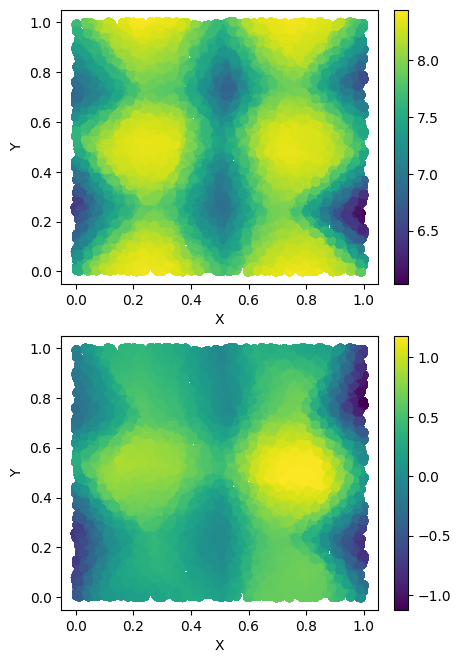

In [34]:
fig = plt.figure(constrained_layout=True,figsize=(14, 12))
gs = GridSpec(4, 4, figure=fig)

ax0 = fig.add_subplot(gs[0,0])
c0 = ax0.scatter(x=results["x"], y=results["y"], c=results["Wqx"], vmax=np.max(results["Wqx"]))
ax0.set(ylabel='Y',xlabel='X')

ax1 = fig.add_subplot(gs[1,0])
c1 = ax1.scatter(x=results["x"], y=results["y"], c=results["Wqy"], vmax=np.max(results["Wqy"]))
ax1.set(ylabel='Y',xlabel='X')

fig.colorbar(c0, ax=ax0)
fig.colorbar(c1, ax=ax1)

fig_filename = os.path.join(parent_dir,'fig','1d-illustration_W.png')
plt.savefig(fig_filename, dpi = 300)
